# Driver Distraction Prediction Using CNN
### MECE 696 - Machine Learning For Engineering - Final Course Project - Aiswarya Pai

#### Multi-Class Classification - If driver is distracted, what is the distracting activity?
##### 2 models: 
##### a. Custom built simple CNN model with 3 Convolutional Layers, Flatten, 2 Dense layers with one droput inbetween and finally an output layer
##### b. Use pretrained ResNet50 model for transfer learning and fine tune it further with additinal layers

##### Import all required packages and prerequisites

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import image_dataset_from_directory

##### Data Preprocessing and Preparation

###### Creating Directory Structure and organizing images in appropriate folders

In [3]:
BASE_DIR = './state-farm-distracted-driver-detection/imgs/train' # path to original dataset's train folder

# Load driver images list from the CSV file shared with the original dataset
df = pd.read_csv('./state-farm-distracted-driver-detection/driver_imgs_list.csv')  # Contains columns: subject, classname, img

# Create a full path to images
df['path'] = df.apply(lambda row: os.path.join('train', row['classname'], row['img']), axis=1)

# Rename columns for clarity
df = df.rename(columns={'classname': 'label', 'img': 'filename'}) 

# Split the data in the original train folder into train (60%), val (20%), test (20%)
# stratify option is used so that each of the splits contrain equal distribution of all labels
train_df, temp_df = train_test_split(df, stratify=df['label'], test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, stratify=temp_df['label'], test_size=0.5, random_state=42)

# Create base directories
# SimpleCNN
parent_dir_cnn = './imgs/cnn_dataset'
train_dir_cnn = os.path.join(parent_dir_cnn, 'train')
val_dir_cnn = os.path.join(parent_dir_cnn, 'val')
test_dir_cnn = os.path.join(parent_dir_cnn, 'test')

# ResNet
parent_dir_resnet = './imgs/resnet_dataset'
train_dir_resnet = os.path.join(parent_dir_resnet, 'train')
val_dir_resnet = os.path.join(parent_dir_resnet, 'val')
test_dir_resnet = os.path.join(parent_dir_resnet, 'test')


for d in [train_dir_cnn, val_dir_cnn, test_dir_cnn, train_dir_resnet, val_dir_resnet, test_dir_resnet]:
    for label in sorted(df['label'].unique()):
        os.makedirs(os.path.join(d, label), exist_ok=True)

In [6]:
train_df['path'] 

9611     train\c3\img_87873.jpg
1526     train\c9\img_84734.jpg
12591    train\c8\img_75852.jpg
13421    train\c8\img_24868.jpg
6946     train\c0\img_47472.jpg
                  ...          
7870     train\c8\img_52914.jpg
10471    train\c5\img_35194.jpg
2141     train\c5\img_92627.jpg
19499    train\c0\img_24623.jpg
359      train\c4\img_62882.jpg
Name: path, Length: 13454, dtype: object

In [7]:
train_dir_cnn, train_dir_resnet

('./imgs/cnn_dataset\\train', './imgs/resnet_dataset\\train')

In [4]:
# Helper to copy images
def copy_images(base, dataframe, target_root):
    for _, row in dataframe.iterrows():
        src_path = os.path.join(base, row['label'], row['filename'])  # original train/ folder
        dst_path = os.path.join(target_root, row['label'], row['filename'])
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)

copy_images(BASE_DIR, train_df, train_dir_cnn)
copy_images(BASE_DIR, val_df, val_dir_cnn)
copy_images(BASE_DIR, test_df, test_dir_cnn)

copy_images(BASE_DIR, train_df, train_dir_resnet)
copy_images(BASE_DIR, val_df, val_dir_resnet)
copy_images(BASE_DIR, test_df, test_dir_resnet)

OSError: [Errno 22] Invalid argument: './imgs/cnn_dataset\\train\\c0\\img_656.jpg'

###### Generating Train, Test and Validation Datasets after Image resizing, rescaling and augumentation

In [16]:
# Simple CNN
(IMG_HEIGHT_CNN, IMG_WIDTH_CNN) = (128, 128)
BATCH_SIZE = 32

train_cnn = image_dataset_from_directory(
    train_dir_cnn,
    image_size = (IMG_HEIGHT_CNN, IMG_WIDTH_CNN),
    batch_size = BATCH_SIZE,
    shuffle = True
)

val_cnn = image_dataset_from_directory(
    val_dir_cnn,
    image_size = (IMG_HEIGHT_CNN, IMG_WIDTH_CNN),
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_cnn = image_dataset_from_directory(
    test_dir_cnn,
    image_size = (IMG_HEIGHT_CNN, IMG_WIDTH_CNN),
    batch_size = 1,
    shuffle = False
)

class_names = train_cnn.class_names

# Resnet50
(IMG_HEIGHT_RESNET, IMG_WIDTH_RESNET) = (224, 224)

train_resnet = image_dataset_from_directory(
    train_dir_resnet,
    image_size = (IMG_HEIGHT_RESNET, IMG_WIDTH_RESNET),
    batch_size = BATCH_SIZE,
    shuffle = True
)

val_resnet = image_dataset_from_directory(
    val_dir_resnet,
    image_size = (IMG_HEIGHT_RESNET, IMG_WIDTH_RESNET),
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_resnet = image_dataset_from_directory(
    test_dir_resnet,
    image_size = (IMG_HEIGHT_RESNET, IMG_WIDTH_RESNET),
    batch_size = 1,
    shuffle = False
)

Found 13454 files belonging to 10 classes.
Found 4485 files belonging to 10 classes.
Found 4485 files belonging to 10 classes.
Found 13454 files belonging to 10 classes.
Found 4485 files belonging to 10 classes.
Found 4485 files belonging to 10 classes.


###### Summary of the dataset

In [41]:
# map label number to activity descriptions
label_desc = {
    0: "safe driving",
    1: "texting - right hand",
    2: "talking on the phone - right hand",
    3: "texting - left hand",
    4: "talking on the phone - left hand",
    5: "operating the radio",
    6: "drinking",
    7: "reaching behind",
    8: "hair and makeup",
    9: "talking to passenger"
}

# Summary of dataset
print("Summary of the Dataset: Distracted_Drivers\n")

# Total number of sample images
def count_images_in_directory(directory):
    total = 0
    for root, _, files in os.walk(directory):
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        total += len(image_files)
    return total

train_count = count_images_in_directory(train_dir_resnet)
val_count = count_images_in_directory(val_dir_resnet)
test_count = count_images_in_directory(test_dir_resnet)
    
print("   After data preprocessing and preparation:")
print("\t Total Number of Training Images for both models: ", train_count)
print("\t Total Number of Validation Images for both models: ", val_count)
print("\t Total Number of Test Images for both models: ", test_count)
print("\t Each Sample Image used in Simple CNN is of size: ", IMG_HEIGHT_CNN, "x", IMG_WIDTH_CNN)
print("\t Each Sample Image used in ResNet50 fine tuned model is of size: ", IMG_HEIGHT_RESNET, "x", IMG_WIDTH_RESNET)
print("\t As these are color images, they will have the last dimension as 3, corresponding to RGB. \n")
print("Project Summary : Driver Distraction Detection using CNN\n")
print("   Objective: To predict if the driver is distracted or not from an image of the driver.")
print("\n   Two Convolutional Neural Network (CNN) models  will be built: \n \t 1. A custom built Simple CNN model \n \t 2. A pretrained ResNet50 model used for transfer learning and fined tuned with further layers")
print("\n   If distracted, the models will classify the type of distraction based on the below activities.\n")
print("   The following activities of the drivers are considered as a distraction:")
for i in range(10):
    print("\t", f"{i}: {label_desc[i]}")

Summary of the Dataset: Distracted_Drivers

   After data preprocessing and preparation:
	 Total Number of Training Images for both models:  13454
	 Total Number of Validation Images for both models:  4485
	 Total Number of Test Images for both models:  4485
	 Each Sample Image used in Simple CNN is of size:  128 x 128
	 Each Sample Image used in ResNet50 fine tuned model is of size:  224 x 224
	 As these are color images, they will have the last dimension as 3, corresponding to RGB. 

Project Summary : Driver Distraction Detection using CNN

   Objective: To predict if the driver is distracted or not from an image of the driver.

   Two Convolutional Neural Network (CNN) models  will be built: 
 	 1. A custom built Simple CNN model 
 	 2. A pretrained ResNet50 model used for transfer learning and fined tuned with further layers

   If distracted, the models will classify the type of distraction based on the below activities.

   The following activities of the drivers are considered a

###### Visualizing a few sample images

Here are a few of the sample images 



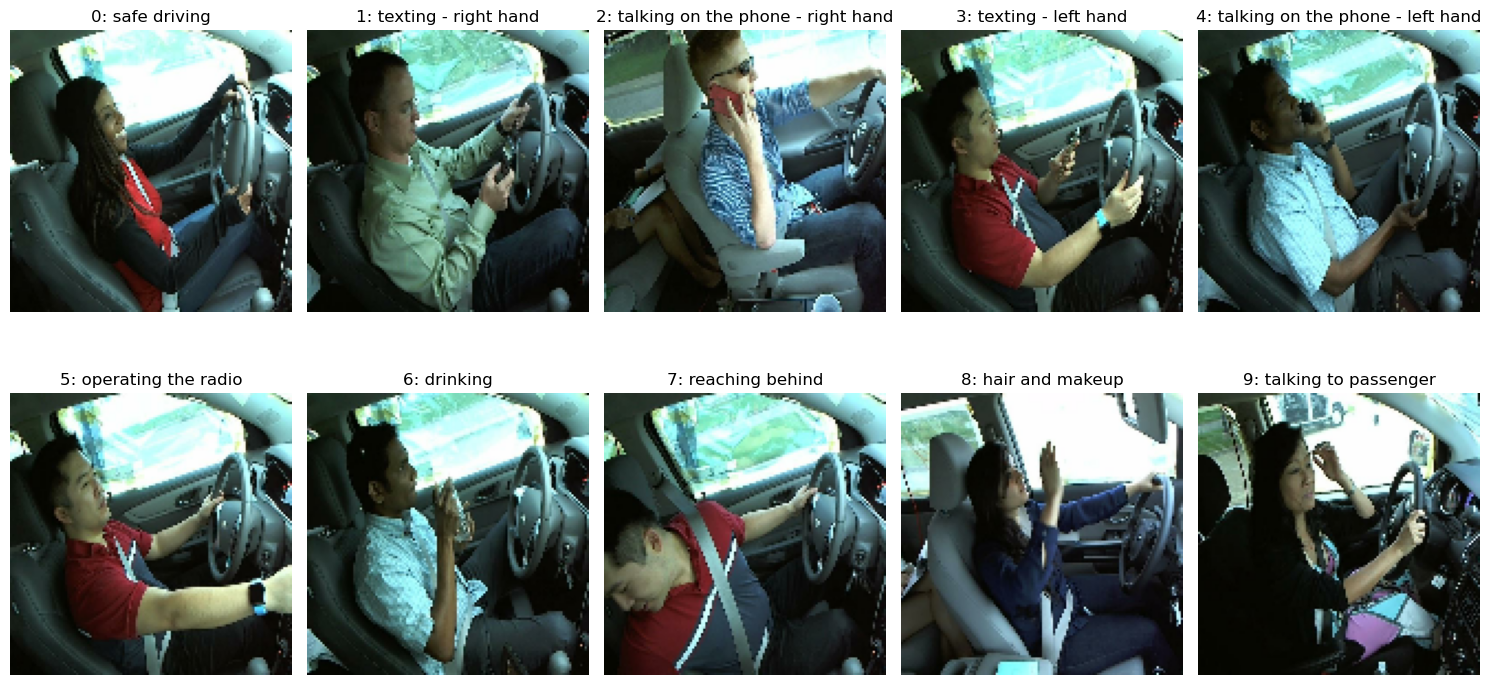

In [43]:
# visualize some sample images
# Get one batch of images and labels
X, y = next(iter(train_cnn))

print("Here are a few of the sample images \n")
plt.figure(figsize=(15, 8))

shown = set()
i = 0
while len(shown) < 10 and i < len(y):
    label = int(y[i])  # sparse labels are integers
    if label not in shown:
        shown.add(label)
        ax = plt.subplot(2, 5, label + 1)
        # Normalize image to 0-1 for imshow
        img = X[i].numpy().astype("uint8")
        #img = img / 255.0
        plt.imshow(img)
        plt.title(f"{label}: {label_desc[label]}")
        plt.axis("off")
    i += 1

plt.tight_layout()
plt.show()

###### Data Augmentation

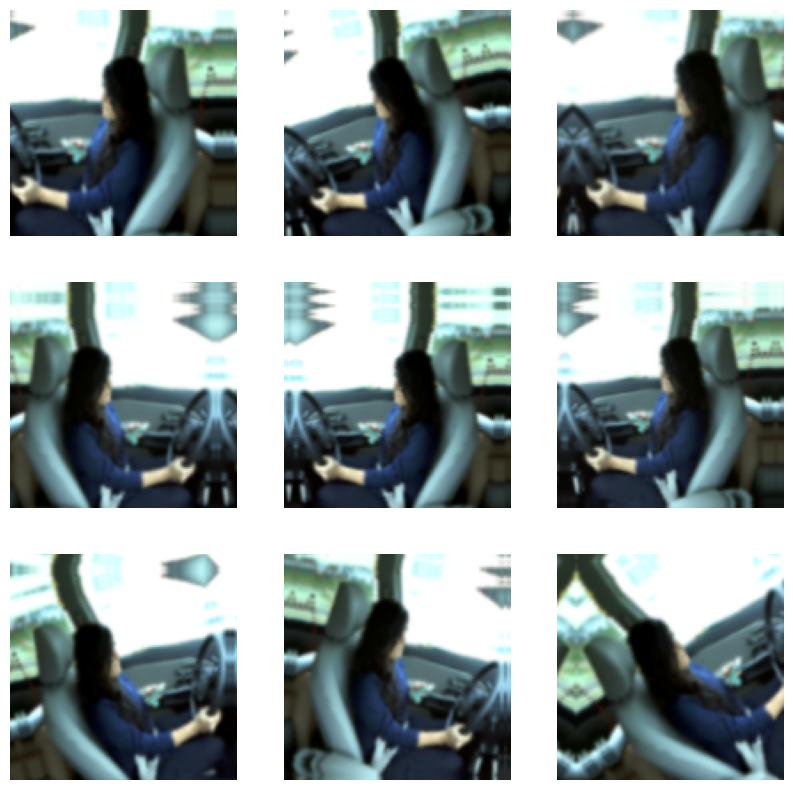

In [17]:
# Data Augmentation using keras.Sequential
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomTranslation(0.1, 0.1)
])

# Apply augmentation during training only
train_cnn = train_cnn.map(lambda x, y: (data_augmentation(x, training=True), y))
train_resnet = train_resnet.map(lambda x, y: (data_augmentation(x, training=True), y))

# Improve performance using caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_cnn = train_cnn.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_cnn = val_cnn.cache().prefetch(buffer_size=AUTOTUNE)

train_resnet = train_resnet.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_resnet = val_resnet.cache().prefetch(buffer_size=AUTOTUNE)

# Visualize augmented images
import matplotlib.pyplot as plt

for images, labels in train_cnn.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

###### Rescaling data

In [18]:
# Simple CNN
from keras.layers import Rescaling
# Create a rescaling layer
rescale = Rescaling(1./255)

# Apply rescaling to the train/val/test sets
train_cnn = train_cnn.map(lambda x, y: (rescale(x), y))
val_cnn = val_cnn.map(lambda x, y: (rescale(x), y))
test_cnn = test_cnn.map(lambda x, y: (rescale(x), y))

# Resnet
from keras.applications.resnet import preprocess_input
def preprocess_resnet(image, label):
    image = preprocess_input(image)
    return image, label
    
# Apply rescaling to the train/val/test sets
train_resnet = train_resnet.map(preprocess_resnet)
val_resnet = val_resnet.map(preprocess_resnet)
test_resnet = test_resnet.map(preprocess_resnet)

In [12]:
# Check rescaling - one batch from the dataset
print("Simple CNN")
for X_batch, y_batch in train_cnn.take(1):
    print("Min pixel value:", tf.reduce_min(X_batch).numpy())
    print("Max pixel value:", tf.reduce_max(X_batch).numpy())

print("ResNet")
for X_batch, y_batch in train_resnet.take(1):
    print("Min pixel value:", tf.reduce_min(X_batch).numpy())
    print("Max pixel value:", tf.reduce_max(X_batch).numpy())
    break  # This ensures only one batch is taken

Simple CNN
Min pixel value: 0.0
Max pixel value: 1.0
ResNet
Min pixel value: -123.67012
Max pixel value: 151.061


##### a. Custom built Simple CNN model

###### Building the CNN model (Adding Layers and compilation)

In [12]:
def create_simple_cnn():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(IMG_HEIGHT_CNN, IMG_WIDTH_CNN, 3)),
        keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation='relu', strides=(1,1)),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        
        keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu', strides=(1,1)),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        
        keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation='relu', strides=(1,1)),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        
        keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation='relu', strides=(1,1)),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        
        keras.layers.Flatten(), # flattening 2D to 1D
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(rate = 0.15), # adding a dropout layer for regularization
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(10, activation='softmax') # output 10 classes, hence softmax and sparse_categorical_crossentropy
    ])
    optimizer = Adam(learning_rate = 0.0001) # to improve training accuracy, default is 0.001
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

dd_cnn = create_simple_cnn() 
dd_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,905,738 (22.53 MB)

 Trainable params: 5,905,738 (22.53 MB)

 Non-trainable params: 0 (0.00 B)

###### Training the model

In [11]:
cnn_log = dd_cnn.fit(train_cnn, validation_data = val_cnn, epochs=20, callbacks = [EarlyStopping(patience = 8, restore_best_weights = True)])

Epoch 1/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 78s 180ms/step - accuracy: 0.1366 - loss: 2.2579 - val_accuracy: 0.3880 - val_loss: 1.6062
Epoch 2/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 62s 147ms/step - accuracy: 0.3705 - loss: 1.6711 - val_accuracy: 0.5701 - val_loss: 1.1872
Epoch 3/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 61s 145ms/step - accuracy: 0.5567 - loss: 1.2094 - val_accuracy: 0.7318 - val_loss: 0.7578
Epoch 4/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 79s 188ms/step - accuracy: 0.7136 - loss: 0.7981 - val_accuracy: 0.7518 - val_loss: 0.6678
Epoch 5/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 57s 135ms/step - accuracy: 0.8154 - loss: 0.5389 - val_accuracy: 0.8118 - val_loss: 0.5708
Epoch 6/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 71s 168ms/step - accuracy: 0.8789 - loss: 0.3473 - val_accuracy: 0.7933 - val_loss: 0.6727
Epoch 7/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 55s 131ms/step - accuracy: 0.9216 - loss: 0.2245 - val_accuracy: 0.8221 - val_loss: 0.6284
Epoch 8/20
421/421 ━━━━━━━━━━━━━━━━━━━━ 57s 135ms/step - accuracy: 0.9558 - loss: 0

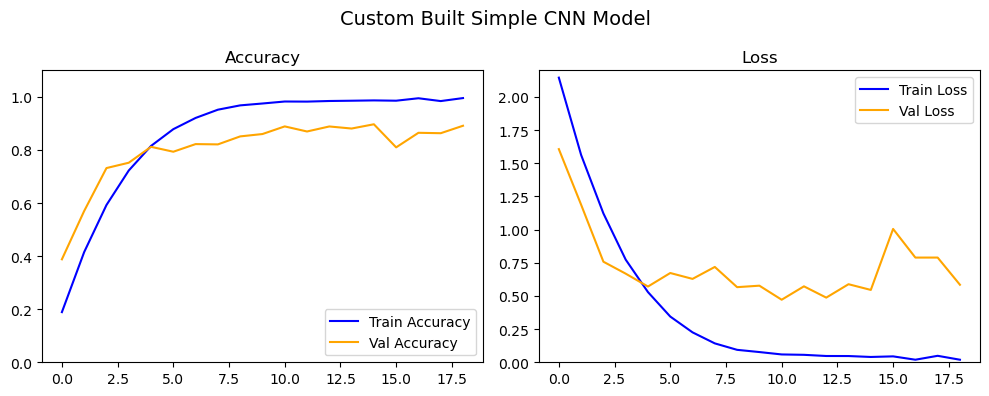

In [13]:
# Plot training history
#plt.title('Fine Tuned ResNet50 CNN Model')
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot Accuracy
ax1.plot(cnn_log.history['accuracy'], label='Train Accuracy', color='blue')
ax1.plot(cnn_log.history['val_accuracy'], label='Val Accuracy', color='orange')
ax1.set_title('Accuracy')
ax1.set_ylim(0.0, 1.1)  # Unified y-axis range
ax1.legend()

# Plot Loss
ax2.plot(cnn_log.history['loss'], label='Train Loss', color='blue')
ax2.plot(cnn_log.history['val_loss'], label='Val Loss', color='orange')
ax2.set_title('Loss')
ax2.set_ylim(0.0, 2.2)  # Unified y-axis range
ax2.legend()

fig.suptitle('Custom Built Simple CNN Model', fontsize=14)
plt.tight_layout()
plt.show()

###### Evaluating and Saving the trained model

In [14]:
print("Evaluating the trained model")
dd_cnn.evaluate(test_cnn)

Evaluating the trained model
4485/4485 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.9375 - loss: 0.2280


[0.4302228093147278, 0.893422544002533]

In [16]:
dd_cnn.save("distracted_drivers_Custom_SimpleCNN.keras")

###### Making predictions using the model and comparing results with actual classes

In [17]:
# creating a smaller test batch to show case predictions
test_ds = keras.utils.image_dataset_from_directory(
    test_dir_cnn,
    image_size = (128, 128),
    batch_size = 1,
    shuffle = True
)

# Take 25 images
test_batch = test_ds.take(25)

predicted_classes = []
true_classes = []

# Collect predictions for each image
for images, labels in test_batch:
    predictions = dd_cnn.predict(images)
    predicted_classes.append(np.argmax(predictions, axis=1)[0])
    true_classes.append(labels.numpy()[0])

# Convert to pandas DataFrame
results_df = pd.DataFrame({
    'True Class': true_classes,
    'Predicted Class': predicted_classes
})

Found 4485 files belonging to 10 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [18]:
# print results
print("Results from the Custom Built Simple CNN Model\n\n", results_df)

Results from the Custom Built Simple CNN Model

     True Class  Predicted Class
0            6                6
1            7                7
2            9                9
3            5                9
4            8                8
5            0                0
6            7                7
7            6                6
8            7                7
9            5                5
10           6                6
11           8                2
12           8                7
13           4                4
14           7                7
15           7                7
16           7                7
17           0                0
18           9                9
19           7                7
20           4                4
21           7                7
22           0                9
23           9                9
24           8                8


##### b. Use Pretrained ResNet50 for transfer learning and fine tune with further layers

###### Loading the pretrained ResNet50 model and Transfer learning with custom layers for Feature Extraction

In [19]:
# Load pretrained ResNet50 without the top layer
base_resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [20]:
# set all the layers apart from last 3 layers of our Resnet50 models as Non-trainable during the training.
for layer in base_resnet.layers[:-3]: 
    layer.trainable = False

# Add custom classification head
last_layer = base_resnet.get_layer('conv5_block2_out')
last_output = last_layer.output

# Build classification head 
head = keras.layers.Flatten() (last_output)
head = keras.layers.Dense(256, activation='relu')(head)
head = keras.layers.Dropout(0.25)(head)
head = keras.layers.Dense(512, activation='relu')(head)
#head = keras.layers.Dense(1024, activation='relu')(head)
head = keras.layers.Dense(10, activation='softmax')(head)

# Connect base and head for the final model
d_resnet = keras.models.Model(inputs=base_resnet.input, outputs=head)
d_resnet.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 44,942,986 (171.44 MB)

 Trainable params: 25,827,082 (98.52 MB)

 Non-trainable params: 19,115,904 (72.92 MB)

In [21]:
#freeze all layers except last 3 for feature extraction
#compile
optimizer = Adam(learning_rate= 1e-4) # to improve training accuracy, default is 0.001
d_resnet.compile(optimizer = optimizer, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

#train
resnet_log = d_resnet.fit(train_resnet, validation_data = val_resnet, epochs=5)

Epoch 1/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.3169 - loss: 2.0163 - val_accuracy: 0.7721 - val_loss: 0.6211
Epoch 2/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 415s 985ms/step - accuracy: 0.7706 - loss: 0.6616 - val_accuracy: 0.8198 - val_loss: 0.5466
Epoch 3/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 435s 969ms/step - accuracy: 0.8870 - loss: 0.3299 - val_accuracy: 0.8988 - val_loss: 0.3016
Epoch 4/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 410s 974ms/step - accuracy: 0.9298 - loss: 0.2057 - val_accuracy: 0.9222 - val_loss: 0.2430
Epoch 5/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 414s 983ms/step - accuracy: 0.9418 - loss: 0.1653 - val_accuracy: 0.9291 - val_loss: 0.2390


In [ ]:
d_resnet.evaluate(test_resnet)

###### Finetuning the model after transfer learning

In [23]:
# Finetuning the model
# Unfreeze deeper layers for fine-tuning
base_resnet.trainable = True

# Fine-tune only the last 35 layers of ResNet50
for layer in base_resnet.layers[:-35]:
    layer.trainable = False

# Recompile with lower LR for fine-tuning
d_resnet.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning phase
resnet_log_finetuning = d_resnet.fit(train_resnet, validation_data = val_resnet, epochs=10, callbacks = [EarlyStopping(patience = 8, restore_best_weights = True)])

Epoch 1/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - accuracy: 0.9863 - loss: 0.0441 - val_accuracy: 0.9347 - val_loss: 0.2352
Epoch 2/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.9887 - loss: 0.0395 - val_accuracy: 0.9402 - val_loss: 0.2154
Epoch 3/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.9902 - loss: 0.0340 - val_accuracy: 0.9333 - val_loss: 0.2241
Epoch 4/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 420s 997ms/step - accuracy: 0.9896 - loss: 0.0298 - val_accuracy: 0.9295 - val_loss: 0.2629
Epoch 5/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 408s 969ms/step - accuracy: 0.9930 - loss: 0.0264 - val_accuracy: 0.9320 - val_loss: 0.2506
Epoch 6/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 414s 984ms/step - accuracy: 0.9923 - loss: 0.0266 - val_accuracy: 0.9215 - val_loss: 0.2905
Epoch 7/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 414s 984ms/step - accuracy: 0.9934 - loss: 0.0247 - val_accuracy: 0.9262 - val_loss: 0.2664
Epoch 8/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 418s 994ms/step - accuracy: 0.9948 - loss: 0.

In [1]:
# Plot training history
#plt.title('Fine Tuned ResNet50 CNN Model')
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot Accuracy
ax1.plot(resnet_log_finetuning.history['accuracy'], label='Train Accuracy', color='blue')
ax1.plot(resnet_log_finetuning.history['val_accuracy'], label='Val Accuracy', color='orange')
ax1.set_title('Accuracy')
ax1.set_ylim(0.5, 1.02)  # Unified y-axis range
ax1.legend()

# Plot Loss
ax2.plot(resnet_log_finetuning.history['loss'], label='Train Loss', color='blue')
ax2.plot(resnet_log_finetuning.history['val_loss'], label='Val Loss', color='orange')
ax2.set_title('Loss')
ax2.set_ylim(0.0, 1.0)  # Unified y-axis range
ax2.legend()

fig.suptitle('Fine-Tuned ResNet50 CNN Model', fontsize=14)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

###### Evaluate and Save the trained fine tuned model

In [25]:
d_resnet.evaluate(test_resnet)

4485/4485 ━━━━━━━━━━━━━━━━━━━━ 232s 52ms/step - accuracy: 0.9118 - loss: 0.2858


[0.21719901263713837, 0.9393534064292908]

In [79]:
# Save the trained model
d_resnet.save("distracted_drivers_Resnet50_Custom.keras")

###### Making predictions

In [86]:
# creating a smaller test batch to show case predictions
test_dsr = keras.utils.image_dataset_from_directory(
    test_dir_resnet,
    image_size = (224, 224),
    batch_size = 1,
    shuffle = True
)
# rescaling
test_dsr = test_dsr.map(lambda x, y: (preprocess_input(x), y))

# Take 25 images
test_batch = test_dsr.take(25)

predicted_classes = []
true_classes = []

# Collect predictions for each image
for images, labels in test_batch:
    predictions = d_resnet.predict(images)
    predicted_classes.append(np.argmax(predictions, axis=1)[0])
    true_classes.append(labels.numpy()[0])

# Convert to pandas DataFrame
results_df = pd.DataFrame({
    'True Class': true_classes,
    'Predicted Class': predicted_classes
})

Found 4485 files belonging to 10 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [87]:
# print results
print("Results from the Fine Tuned ResNet50 CNN Model\n\n", results_df)

Results from the Fine Tuned ResNet50 CNN Model

     True Class  Predicted Class
0            2                3
1            0                3
2            1                3
3            8                4
4            3                3
5            0                3
6            4                3
7            9                3
8            1                3
9            0                8
10           6                3
11           3                3
12           0                3
13           0                3
14           9                3
15           2                8
16           6                3
17           9                0
18           2                3
19           9                3
20           9                0
21           1                3
22           9                8
23           7                3
24           6                0


In [88]:
# Comparing the results
compare_models = pd.DataFrame({
    'Models' : ['Custom Built Simple CNN', 'Fine tuned ResNet50'],
    'Training Accuracy': [0.9930, 1.0],
    'Validation Accuracy': [0.8912, 0.9394],
    'Test Accuracy': [0.9375,0.9768]
})
compare_models

,Models,Training Accuracy,Validation Accuracy,Test Accuracy
0,Custom Built Simple CNN,0.9903,0.8843,0.9223
1,Fine tuned ResNet50,1.0000,0.9394,0.9768


In [ ]:
#confusion matrix, class probabilities